# Visualize network activations during inference

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from yolo.models import ResNetBackbone, YOLOv1

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
activations = {}


def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()

    return hook


def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(hook_fn(name))


def load_model(
    checkpoint_path: str,
    num_classes: int = 20,
    freeze_backbone: bool = False,
    device: str = "cuda",
) -> YOLOv1:
    # Create model with same architecture as training
    backbone = ResNetBackbone(pretrained=False, freeze=freeze_backbone)
    model = YOLOv1(backbone=backbone, num_classes=num_classes, S=7, B=2)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model weights
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device)

    return model


def visualize_activations(activations: dict):
    # visualize feature maps
    for name, act in activations.items():
        plt.figure()
        plt.title(name)
        plt.imshow(act[0][0].numpy(), cmap="gray")
        plt.show()


In [ ]:
from yolo.inference import YOLOInference

# load model
model = load_model(
    checkpoint_path="../checkpoints/yolo_best_v3.pth",
    device=DEVICE,
)

# register hooks
register_hooks(model)

inference = YOLOInference(model, device=DEVICE)

In [ ]:
# run a sample
image_path = "sample.jpg"
detections = inference.predict(
    image_path=image_path, conf_threshold=0.1, nms_threshold=0.4
)

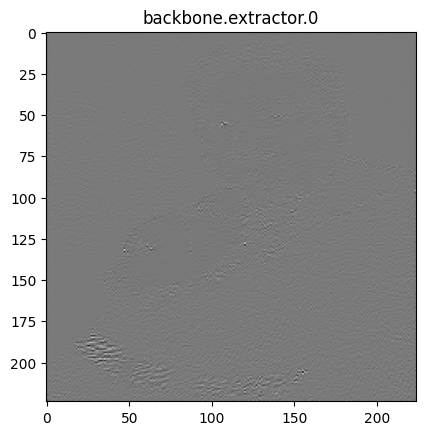

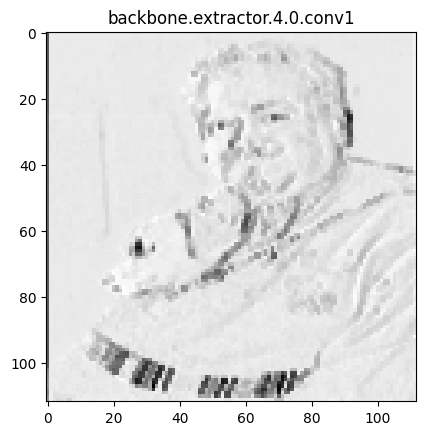

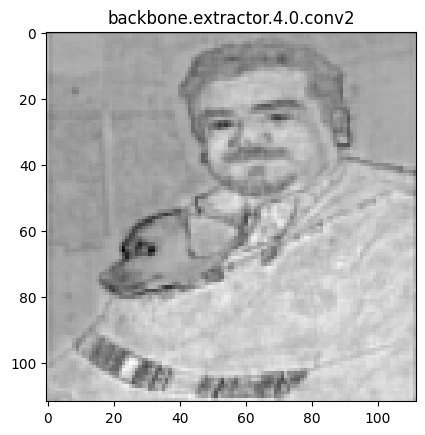

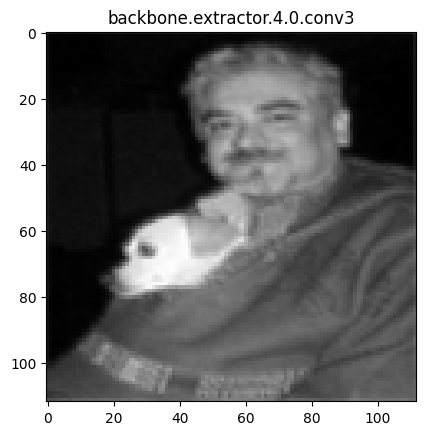

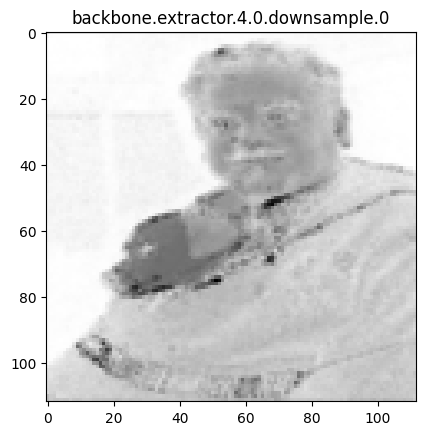

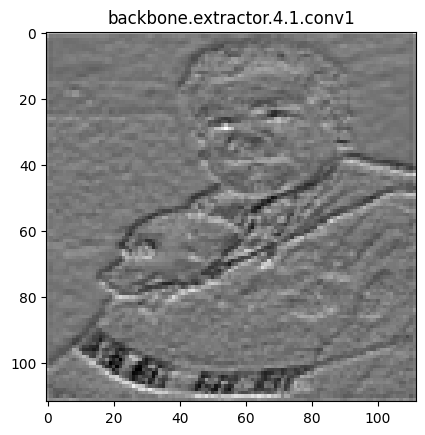

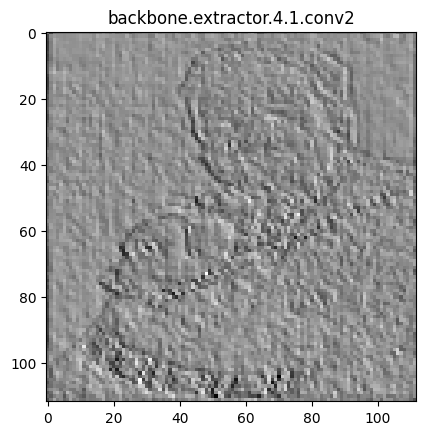

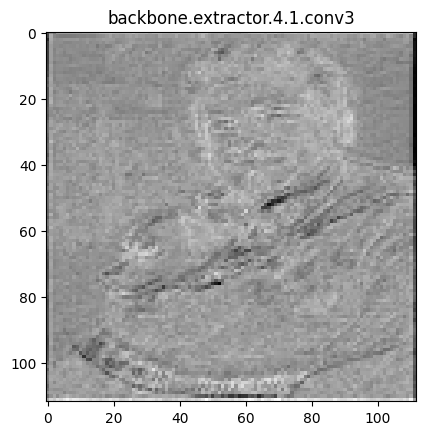

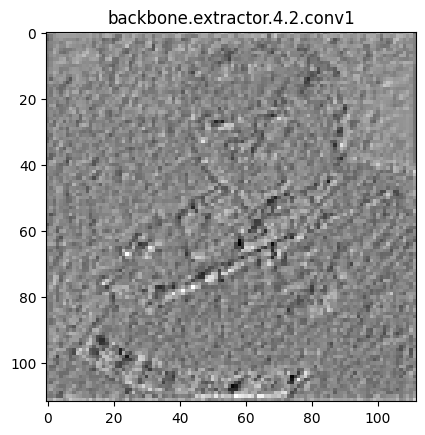

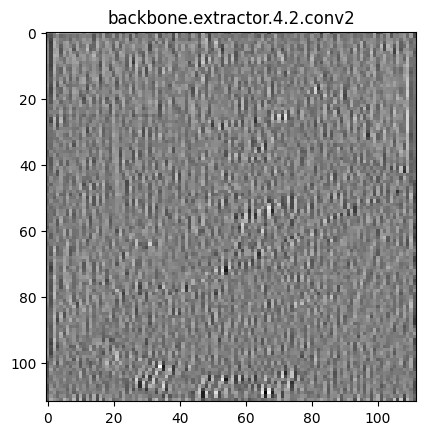

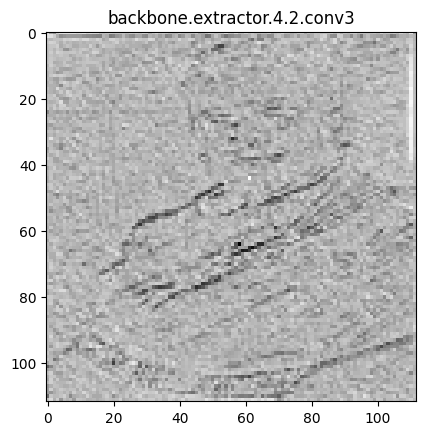

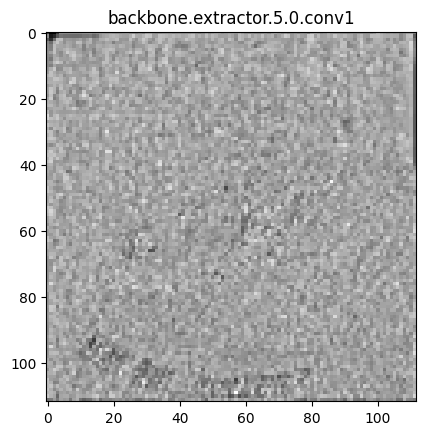

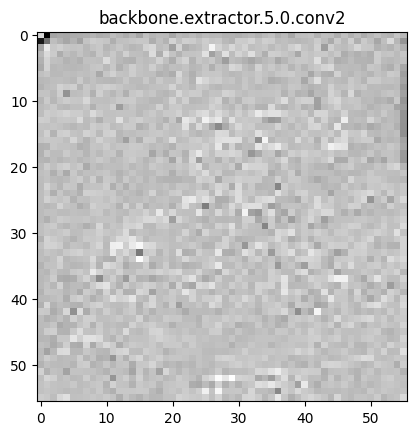

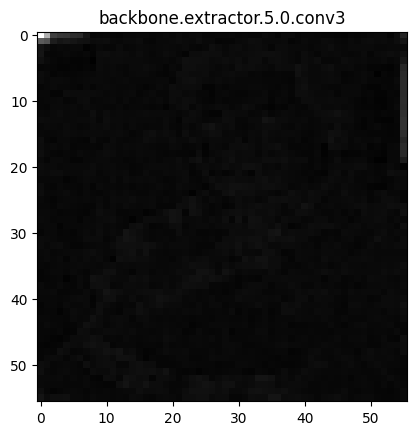

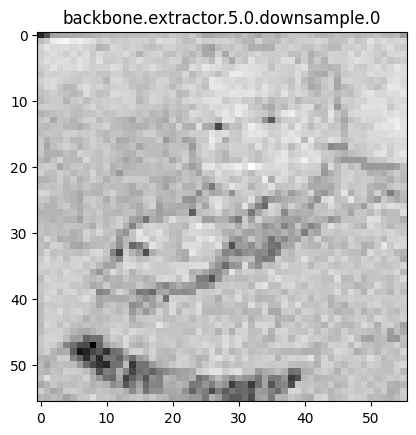

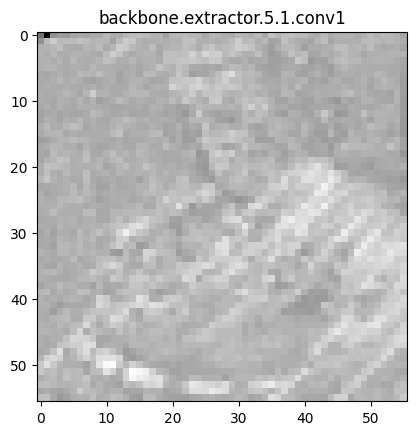

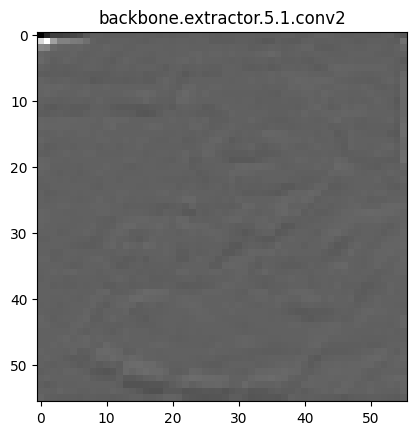

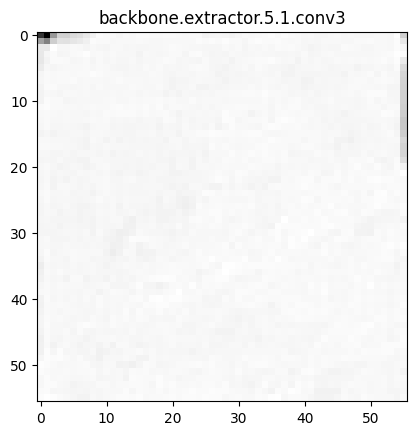

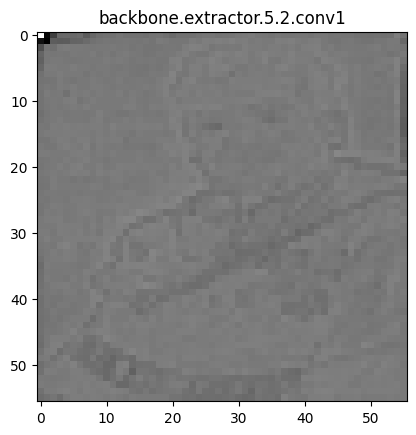

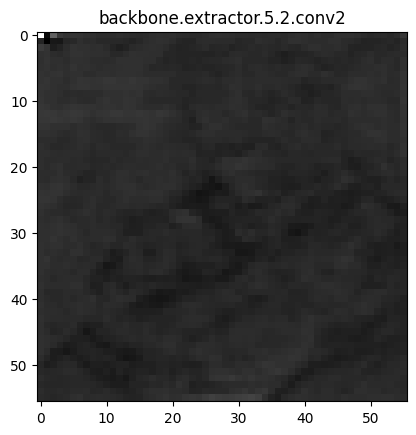

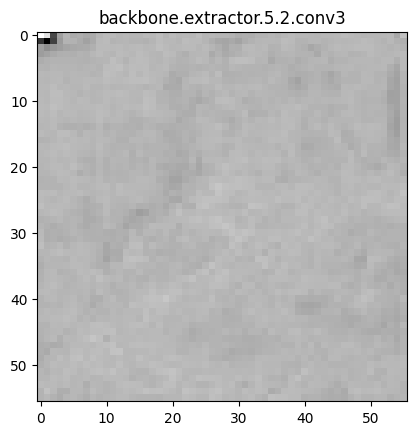

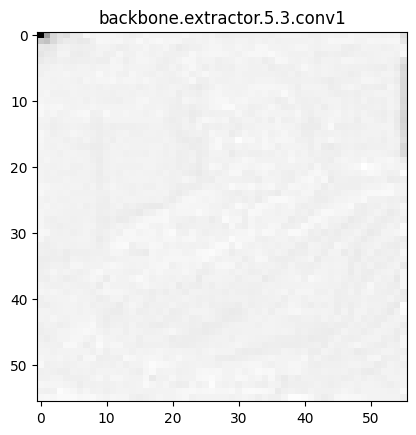

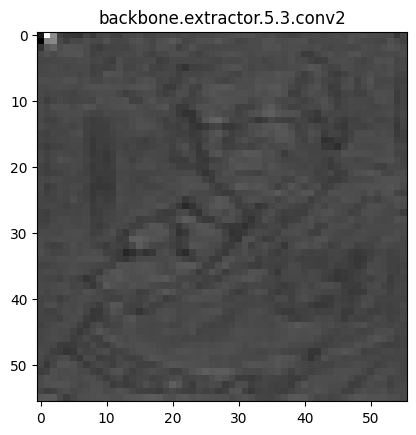

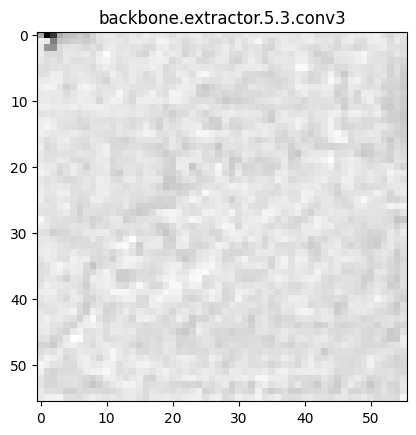

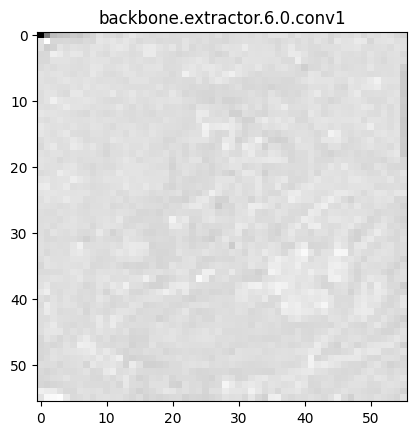

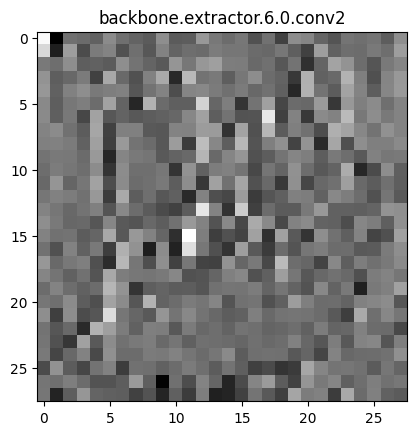

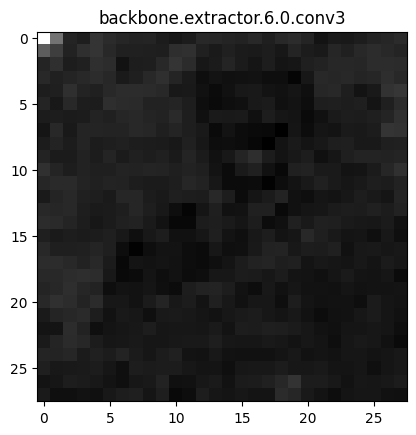

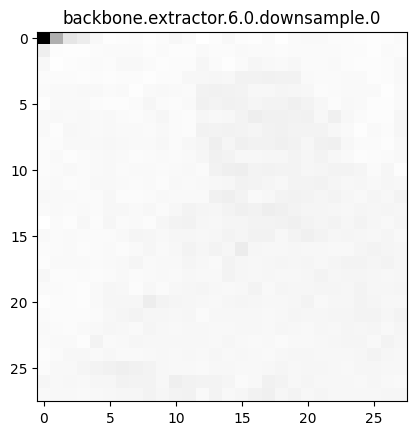

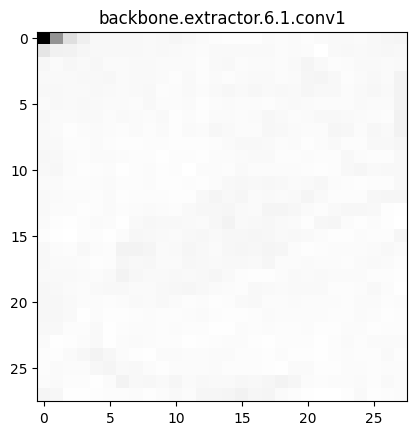

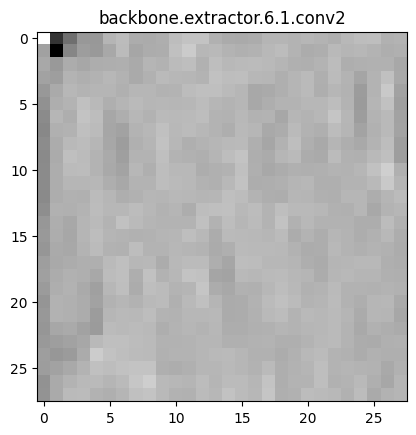

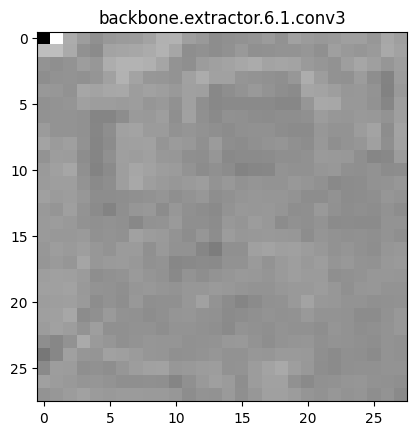

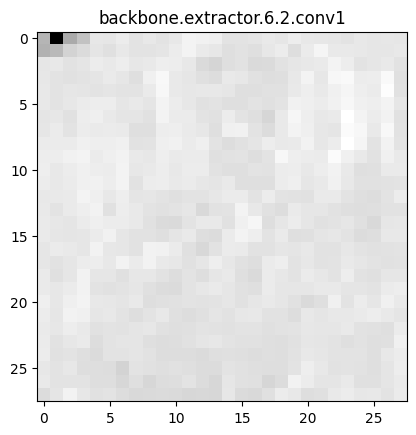

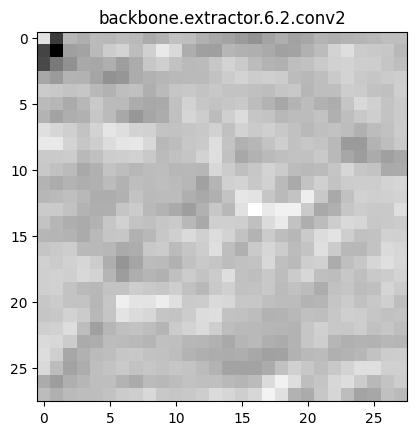

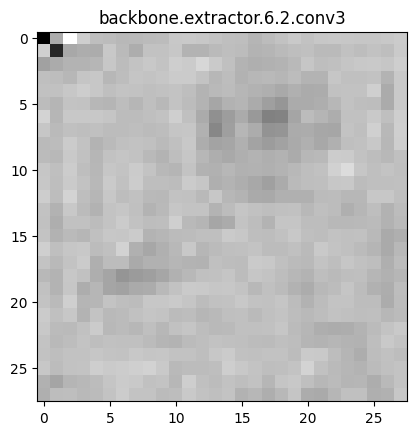

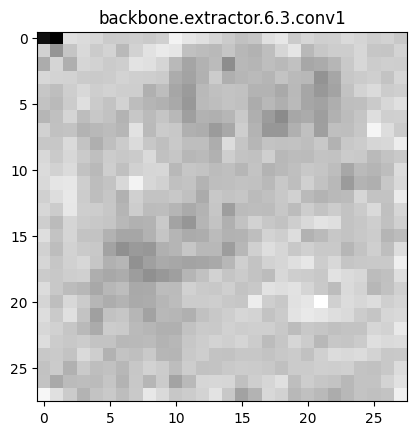

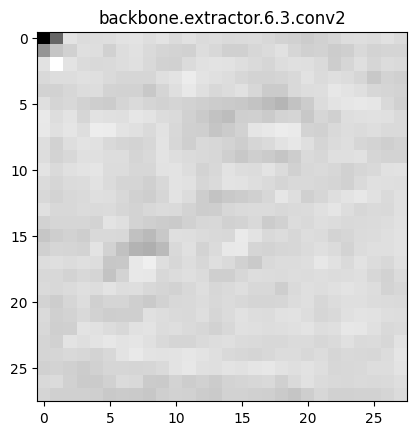

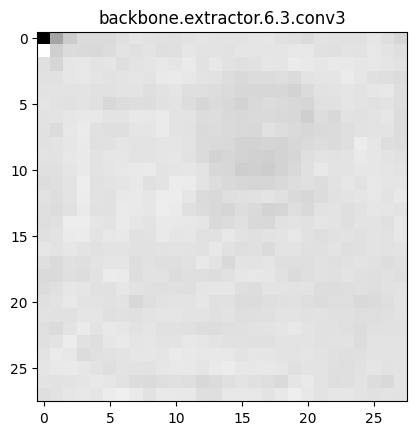

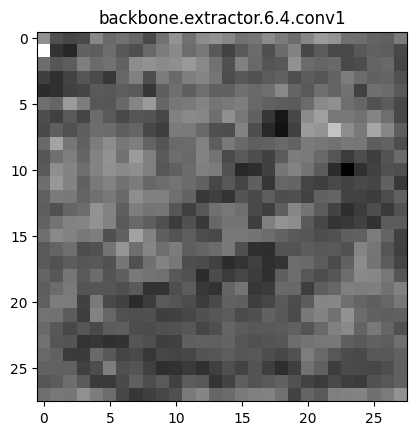

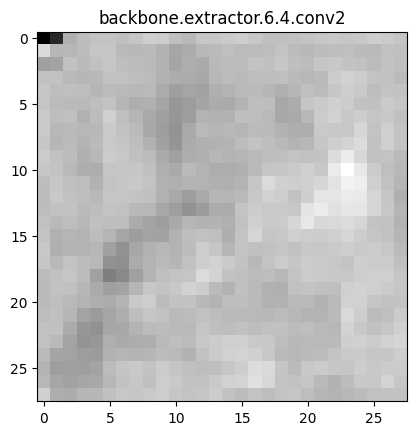

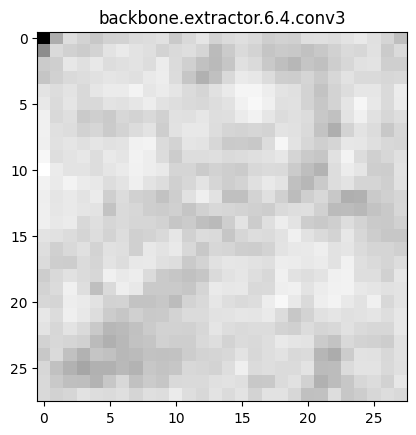

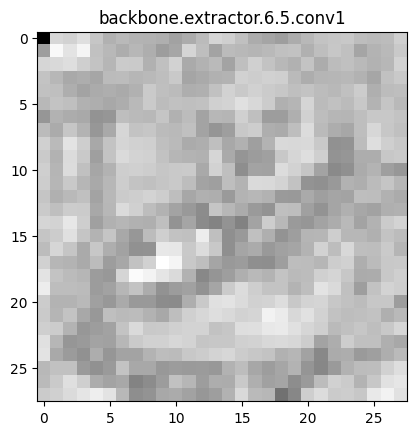

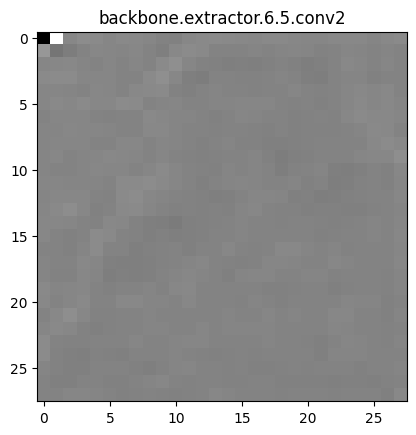

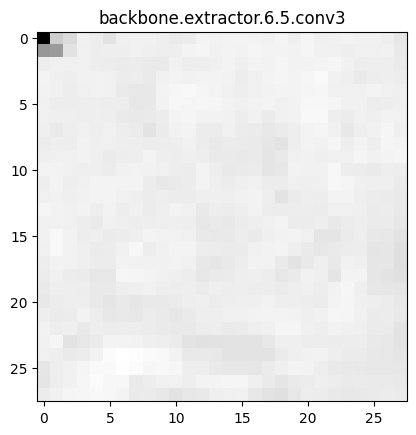

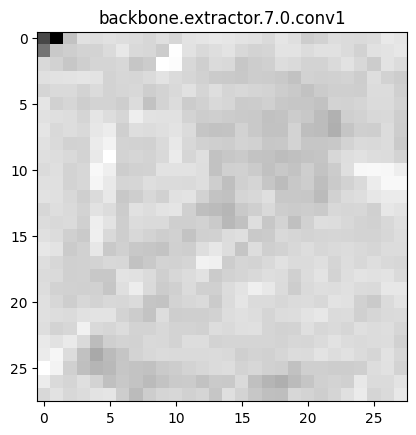

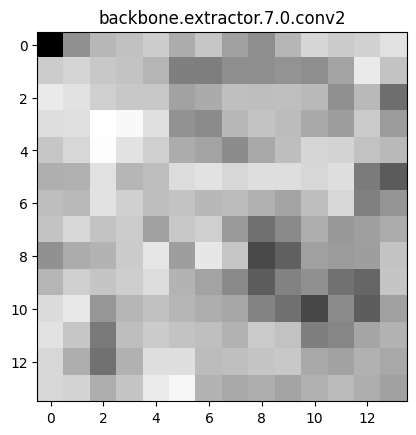

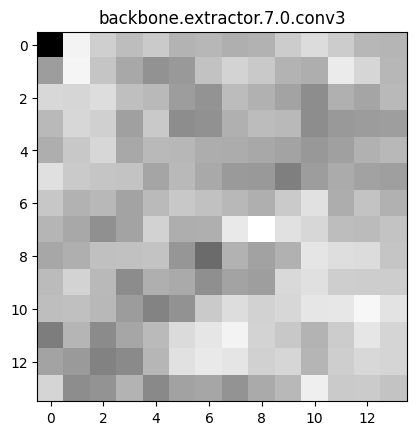

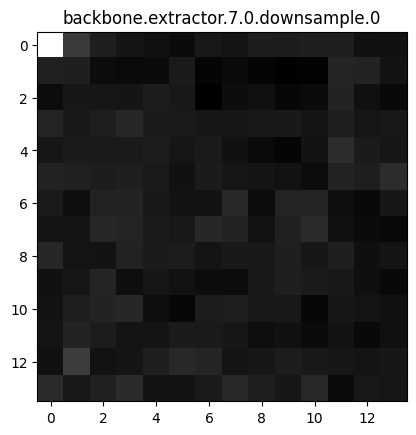

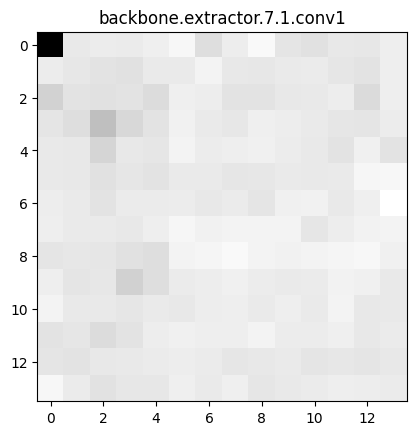

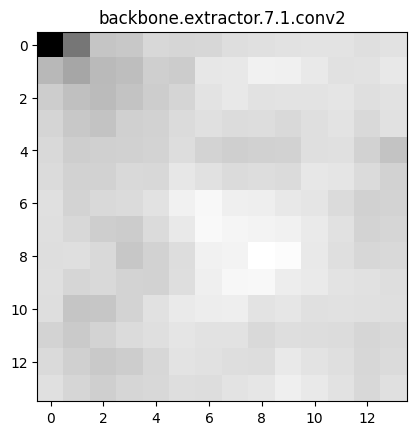

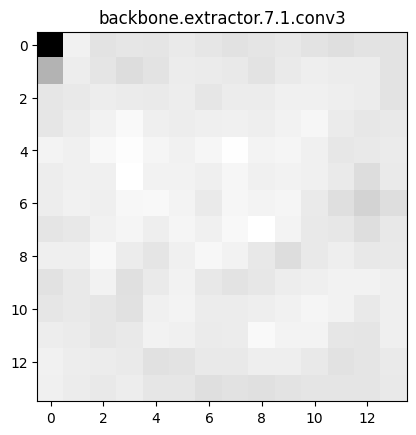

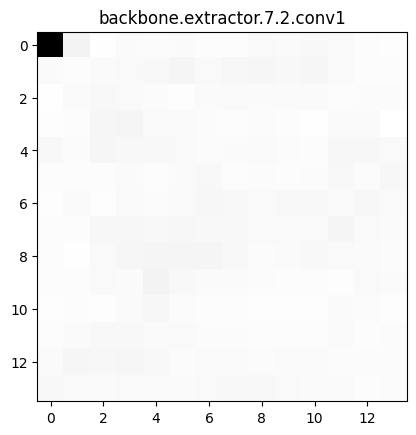

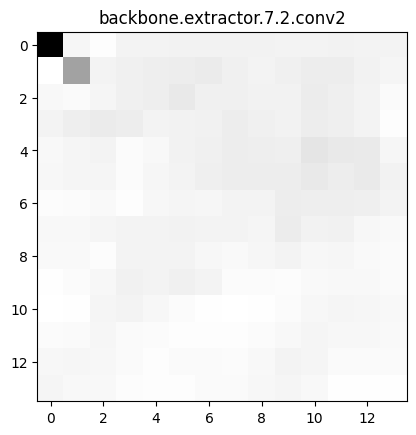

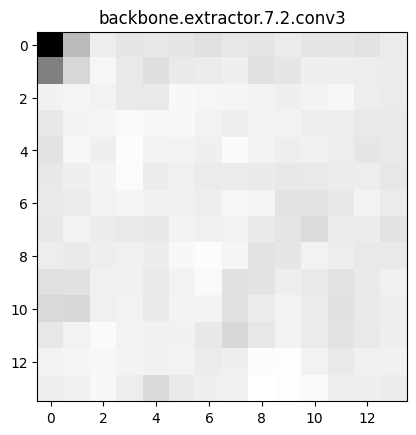

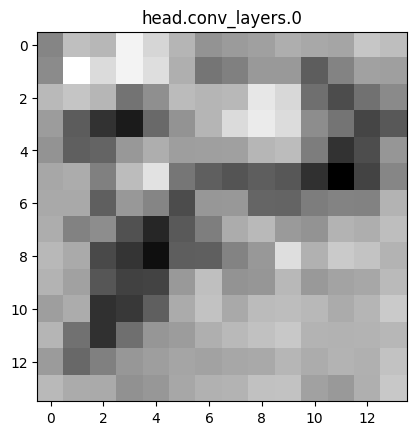

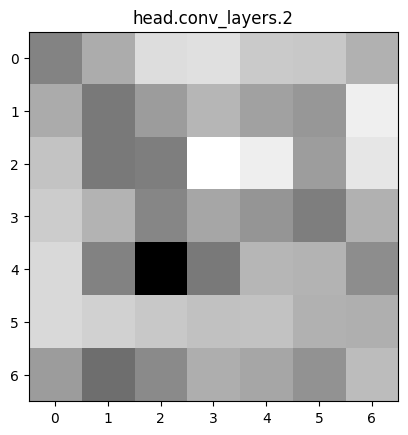

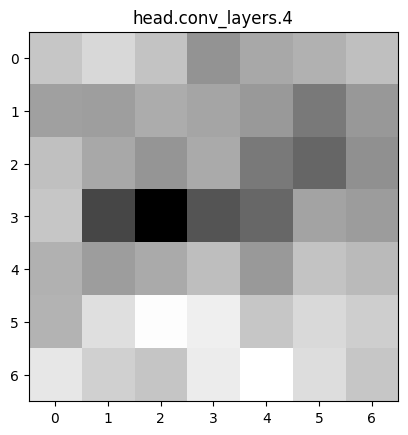

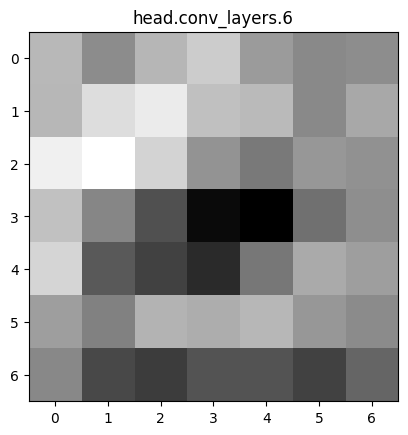

In [40]:
# visualize feature maps
visualize_activations(activations)

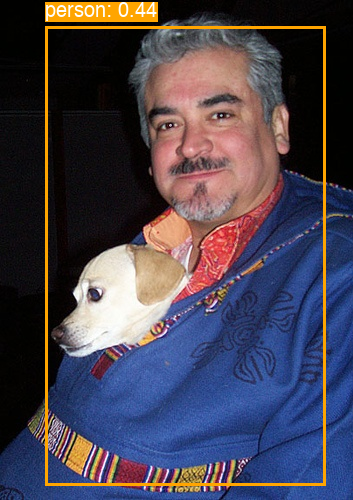

In [ ]:
# draw predictions on image
from PIL import Image
from yolo.utils.visualization import draw_predictions, VOC_CLASSES

image = Image.open(image_path).convert("RGB")
img_with_boxes = draw_predictions(image=image, detections=detections, class_names=VOC_CLASSES, conf_threshold=0.1)
img_with_boxes